In [2]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")
gcm_data = pd.read_pickle("../data/ortiz-bobea/data2/gcm_data.pkl")
data_len = len(data.fd_tmean)

# Build model

In [11]:
# year and country fixed effect coefficient matrices
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.ISO3)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.ISO3 != curr_country:
        country_index += 1
        curr_country = row.ISO3
    year_index = row.year - 1962
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [15]:
with pm.Model() as model:

    fd_temp_prior = pm.Normal("fd_temp_prior", np.mean(data.fd_tmean), np.std(data.fd_tmean))
    fd_temp_std = pm.HalfNormal("fd_temp_std", 10)
    fd_temp_posterior = pm.Normal("fd_temp_posterior", fd_temp_prior, fd_temp_std, observed=data.fd_tmean)

    fd_sq_temp_prior = pm.Normal("fd_sq_temp_prior", np.mean(data.fd_tmean_sq), np.std(data.fd_tmean_sq))
    fd_sq_temp_std = pm.HalfNormal("fd_sq_temp_std", 10)
    fd_sq_temp_posterior = pm.Normal("fd_sq_temp_posterior", fd_sq_temp_prior, fd_sq_temp_std, observed=data.fd_tmean_sq)

    precip_year_coefs = pt.expand_dims(pm.Normal("precip_year_coefs", 0, 5, shape=(len(set(data.year)))),axis=1)
    precip_year_fixed_effects = pm.Deterministic("precip_year_fixed_effects",pt.sum(precip_year_coefs*year_mult_mat,axis=0))

    precip_country_coefs = pt.expand_dims(pm.Normal("precip_country_coefs", 0, 5, shape=(len(set(data.ISO3)))),axis=1)
    precip_country_fixed_effects = pm.Deterministic("precip_country_fixed_effects",pt.sum(precip_country_coefs*country_mult_mat,axis=0))

    precip_intercept = pm.Normal('precip_intercept',0,10)
    temp_precip_coef = pm.Normal('temp_precip_coef',0,10)
    temp_sq_precip_coef = pm.Normal('temp_sq_precip_coef',0,10)

    fd_precip_prior = pm.Deterministic(
    	"fd_precip_prior",
    	precip_intercept + 
    	fd_temp_posterior * temp_precip_coef +
    	fd_sq_temp_posterior * temp_sq_precip_coef +
    	precip_year_fixed_effects +
    	precip_country_fixed_effects
    )

    # fd_precip_prior = pm.Normal("fd_precip_prior", np.mean(data.fd_prcp), np.std(data.fd_prcp))
    fd_precip_std = pm.HalfNormal("fd_precip_std", 10)
    fd_precip_posterior = pm.Normal("fd_precip_posterior", fd_precip_prior, fd_precip_std, observed=data.fd_prcp)

    precip_sq_year_coefs = pt.expand_dims(pm.Normal("precip_sq_year_coefs", 0, 5, shape=(len(set(data.year)))),axis=1)
    precip_sq_year_fixed_effects = pm.Deterministic("precip_sq_year_fixed_effects_sq",pt.sum(precip_sq_year_coefs*year_mult_mat,axis=0))

    precip_sq_country_coefs = pt.expand_dims(pm.Normal("precip_sq_country_coefs", 0, 5, shape=(len(set(data.ISO3)))),axis=1)
    precip_sq_country_fixed_effects = pm.Deterministic("precip_sq_country_fixed_effects",pt.sum(precip_sq_country_coefs*country_mult_mat,axis=0))

    precip_sq_intercept = pm.Normal('precip_sq_intercept',0,10)
    temp_precip_sq_coef = pm.Normal('temp_precip_sq_coef',0,10)
    temp_sq_precip_sq_coef = pm.Normal('temp_sq_precip_sq_coef',0,10)

    fd_sq_precip_prior = pm.Deterministic(
    	"fd_sq_precip_prior",
    	precip_sq_intercept + 
    	fd_temp_posterior * temp_precip_sq_coef +
    	fd_sq_temp_posterior * temp_sq_precip_sq_coef +
    	precip_sq_year_fixed_effects +
    	precip_sq_country_fixed_effects
    )

    # fd_sq_precip_prior = pm.Normal("fd_sq_precip_prior", np.mean(data.fd_prcp_sq), np.std(data.fd_prcp_sq))
    fd_sq_precip_std = pm.HalfNormal("fd_sq_precip_std", 10)
    fd_sq_precip_posterior = pm.Normal("fd_sq_precip_posterior", fd_sq_precip_prior, fd_sq_precip_std, observed=data.fd_prcp_sq)

    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    fd_temp_tfp_coef = pm.Normal('fd_temp_tfp_coef',0,10)
    fd_sq_temp_tfp_coef = pm.Normal('fd_sq_temp_tfp_coef',0,10)
    fd_precip_tfp_coef = pm.Normal("fd_precip_tfp_coef",0,10)
    fd_sq_precip_tfp_coef = pm.Normal("fd_sq_precip_tfp_coef",0,10)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum((year_coefs*year_mult_mat),axis=0))

    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 10, shape=(len(set(data.ISO3)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum((country_coefs*country_mult_mat),axis=0))
    
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (fd_temp_tfp_coef * fd_temp_posterior) +
        (fd_sq_temp_tfp_coef * fd_sq_temp_posterior) +
        (fd_precip_tfp_coef * fd_precip_posterior) +
        (fd_sq_precip_tfp_coef * fd_sq_precip_posterior) +
        year_fixed_effects +
        country_fixed_effects
    )
    
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=data.fd_log_tfp)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=0.99)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [country_coefs, fd_precip_posterior, fd_precip_std, fd_precip_tfp_coef, fd_sq_precip_posterior, fd_sq_precip_std, fd_sq_precip_tfp_coef, fd_sq_temp_posterior, fd_sq_temp_prior, fd_sq_temp_std, fd_sq_temp_tfp_coef, fd_temp_posterior, fd_temp_prior, fd_temp_std, fd_temp_tfp_coef, precip_country_coefs, precip_intercept, precip_sq_country_coefs, precip_sq_intercept, precip_sq_year_coefs, precip_year_coefs, temp_precip_coef, temp_precip_sq_coef, temp_sq_precip_coef, temp_sq_precip_sq_coef, tfp_intercept, tfp_posterior, tfp_std, year_coefs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fd_temp_prior, fd_temp_std, fd_sq_temp_prior, fd_sq_temp_std, precip_year_coefs, precip_country_coefs, precip_intercept, temp_precip_coef, temp_sq_precip_coef, fd_precip_std, precip_sq_year_coefs, precip_sq_country_coefs, precip_sq_intercept, temp_precip_sq_coef, temp_sq_precip_sq_coef, fd_sq_precip_std, tfp_intercept, fd

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1829 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [fd_precip_posterior, fd_sq_precip_posterior, fd_sq_temp_posterior, fd_temp_posterior, tfp_posterior]


# Add observed data to model and sample

In [19]:
observed_model = observe(model, {
    "fd_temp_posterior":data.fd_tmean,
    "fd_sq_temp_posterior":data.fd_tmean_sq,
    "fd_precip_posterior":data.fd_prcp,
    "fd_sq_precip_posterior":data.fd_prcp_sq,
    "tfp_posterior":data.fd_log_tfp
})

with observed_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

# with open ('../models/ortiz-bobea-reproduction-year-country-fixed-effects.pkl', 'wb') as buff:
#     pkl.dump({
#         "prior":prior,
#         "trace":trace,
#         "posterior":posterior
#     },buff)

Sampling: [fd_precip_posterior, fd_precip_prior, fd_precip_std, fd_precip_tfp_coef, fd_sq_precip_posterior, fd_sq_precip_prior, fd_sq_precip_std, fd_sq_precip_tfp_coef, fd_sq_temp_posterior, fd_sq_temp_prior, fd_sq_temp_std, fd_sq_temp_tfp_coef, fd_temp_posterior, fd_temp_prior, fd_temp_std, fd_temp_tfp_coef, tfp_intercept, tfp_posterior, tfp_std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fd_temp_prior, fd_temp_std, fd_sq_temp_prior, fd_sq_temp_std, fd_precip_prior, fd_precip_std, fd_sq_precip_prior, fd_sq_precip_std, tfp_intercept, fd_temp_tfp_coef, fd_sq_temp_tfp_coef, fd_precip_tfp_coef, fd_sq_precip_tfp_coef, tfp_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 199 seconds.
Sampling: [fd_precip_posterior, fd_sq_precip_posterior, fd_sq_temp_posterior, fd_temp_posterior, tfp_posterior]


# Estimate historical anthropogenic effect on TFP

In [3]:
# Green months
green_months = {}
green_month_data = pd.read_csv("../data/ortiz-bobea/data2/ndvi_co/peak_bottom_ndvi_month_country.csv")
for row in green_month_data.itertuples():
    peak = row[5]
    season = [i for i in range(peak-2,peak+3)]
    for i in range(len(season)):
        if season[i] < 1:
            season[i] = season[i] + 12
        elif season[i] > 12:
            season[i] = season[i] - 12
    green_months[row.ISO3] = season

In [6]:
## DO NOT RUN UNLESS GCM_DATA.PKL IS MISSING

gcms = ["BCC-CSM2-MR","CanESM5","CNRM-CM6-1","HadGEM3-GC31-LL","IPSL-CM6A-LR","MIROC6","MRI-ESM2-0"]
gcm_data = {gcm:{"hist_temp":{},"hist_prcp":{},"hist_nat_temp":{},"hist_nat_prcp":{}} for gcm in gcms}

for gcm in gcms:
    print(gcm)
    try:
        hist_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/historical_{gcm}_1948-2020_cropland.csv")
    except FileNotFoundError:
        hist_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/historical_{gcm}_1950-2020_cropland.csv")
    try:
        hist_nat_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/hist-nat_{gcm}_1948-2020_cropland.csv")
    except FileNotFoundError:
        hist_nat_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/hist-nat_{gcm}_1950-2020_cropland.csv")

    hist_temp, hist_nat_temp, hist_prcp, hist_nat_prcp = {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}
    
    for year in range(1961,2021):
        for country in set(data.ISO3):
    
            hist_rows = hist_data.loc[(hist_data["year"] == year) & (hist_data["ISO3"] == country)]
            hist_rows = [row for row in hist_rows.itertuples() if row.month in green_months[country]]
        
            nat_rows = hist_nat_data.loc[(hist_nat_data["year"] == year) & (hist_nat_data["ISO3"] == country)]
            nat_rows = [row for row in nat_rows.itertuples() if row.month in green_months[country]]
            
            hist_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in hist_rows]))
            hist_prcp[country].append(np.sum([row.pr for row in hist_rows]))
        
            hist_nat_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in nat_rows]))
            hist_nat_prcp[country].append(np.sum([row.pr for row in nat_rows]))

    gcm_data[gcm]["hist_temp"] = hist_temp
    gcm_data[gcm]["hist_prcp"] = hist_prcp
    gcm_data[gcm]["hist_nat_temp"] = hist_nat_temp
    gcm_data[gcm]["hist_nat_prcp"] = hist_nat_prcp

with open ("../data/ortiz-bobea/data2/gcm_data.pkl", 'wb') as buff:
    pkl.dump(gcm_data,buff)

BCC-CSM2-MR


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f22d8e0cee0>>
Traceback (most recent call last):
  File "/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


AttributeError: 'Axes' object has no attribute 'ravel'

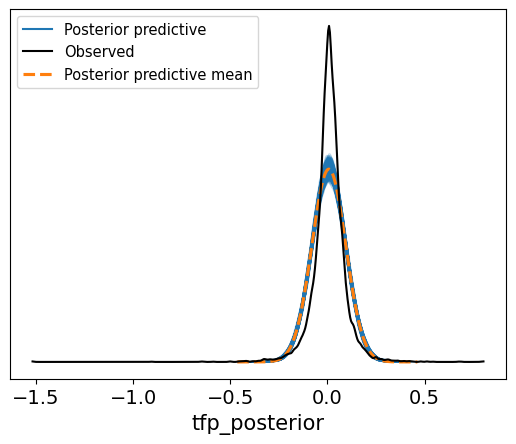

In [7]:
fig = az.plot_ppc(posterior,var_names=["tfp_posterior"]).ravel()[0].figure
fig.show()

/tmp/ipykernel_14392/1434983256.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


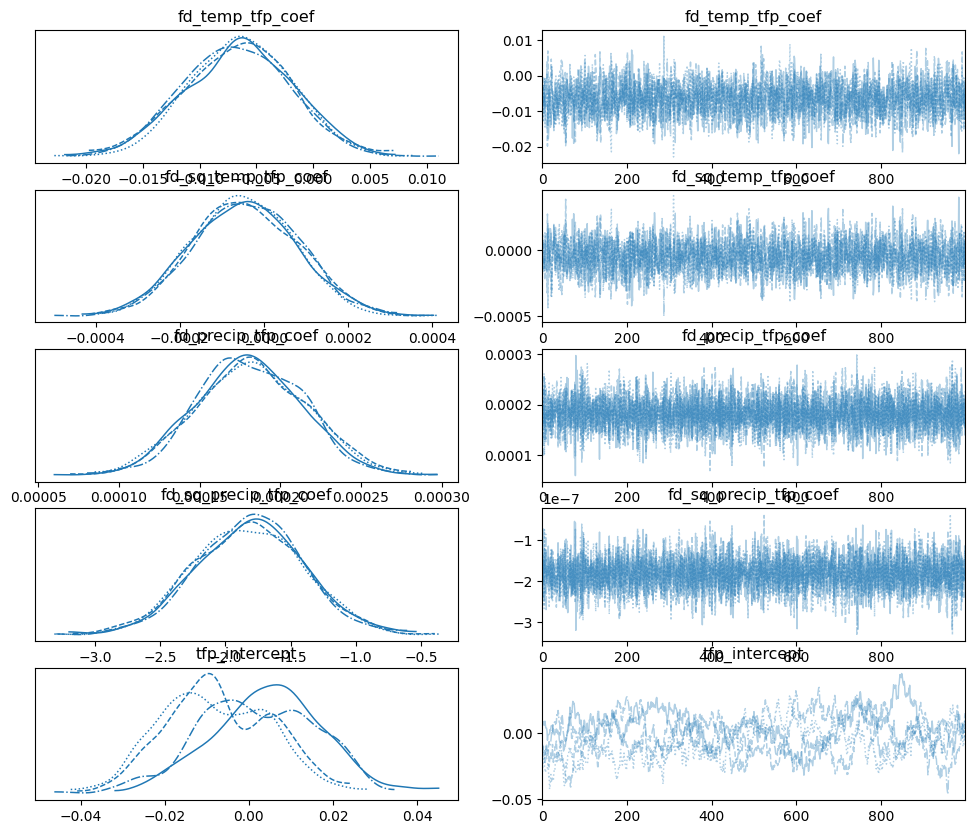

In [24]:
fig = az.plot_trace(trace, var_names=["fd_temp_tfp_coef","fd_sq_temp_tfp_coef","fd_precip_tfp_coef","fd_sq_precip_tfp_coef","tfp_intercept"]).ravel()[0].figure
fig.show()

In [25]:
az.summary(trace, var_names=["fd_temp_tfp_coef","fd_sq_temp_tfp_coef","fd_precip_tfp_coef","fd_sq_precip_tfp_coef","tfp_intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fd_temp_tfp_coef,-0.007,0.005,-0.015,0.002,0.000,0.000,2567.0,2651.0,1.00
fd_sq_temp_tfp_coef,-0.000,0.000,-0.000,0.000,0.000,0.000,2599.0,2610.0,1.00
fd_precip_tfp_coef,0.000,0.000,0.000,0.000,0.000,0.000,6848.0,2712.0,1.00
fd_sq_precip_tfp_coef,-0.000,0.000,-0.000,-0.000,0.000,0.000,6284.0,3218.0,1.00
tfp_intercept,-0.002,0.014,-0.028,0.024,0.003,0.002,24.0,134.0,1.14


# Calculate impacts

In [5]:
# Revenue Weights
revenue_data = pd.read_csv("../data/ortiz-bobea/data/TFP_USDA/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(data.ISO3):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

In [6]:
# Historical climate means
country_climate_means = {}
country_1961_means = {}
ccm_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_means.csv")
for row in ccm_file.itertuples():
    country_climate_means[row[2]] = {"mean_temp":row[3], "mean_prcp":row[4]}
c1961_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_1961.csv")
for row in c1961_file.itertuples():
    country_1961_means[row[2]] = {"mean_temp":row[6],"mean_prcp":row[4]}

In [7]:
temp_hist_dev, temp_nat_dev, prcp_hist_dev, prcp_nat_dev = {}, {}, {}, {}
t1, t2, p1, p2 = {}, {}, {}, {}
t_diff, t_2_diff, p_diff, p_2_diff, = {}, {}, {}, {}

for gcm in gcm_data:
    
    temp_hist_dev[gcm] = {}
    temp_nat_dev[gcm] = {}
    prcp_hist_dev[gcm] = {}
    prcp_nat_dev[gcm] = {}
    t1[gcm] = {}
    t2[gcm] = {}
    p1[gcm] = {}
    p2[gcm] = {}
    t_diff[gcm] = {}
    p_diff[gcm] = {}
    t_2_diff[gcm] = {}
    p_2_diff[gcm] = {}
    
    for country in set(data.ISO3):
    
        temp_hist_dev[gcm][country] = np.array(gcm_data[gcm]["hist_temp"][country]) - country_climate_means[country]["mean_temp"]
        temp_nat_dev[gcm][country] = np.array(gcm_data[gcm]["hist_nat_temp"][country]) - country_climate_means[country]["mean_temp"]
        prcp_hist_dev[gcm][country] = 1 + (np.array(gcm_data[gcm]["hist_prcp"][country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
        prcp_nat_dev[gcm][country] = 1 + (np.array(gcm_data[gcm]["hist_nat_prcp"][country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
        
        t1[gcm][country] = temp_nat_dev[gcm][country] + country_1961_means[country]["mean_temp"]
        t2[gcm][country] = temp_hist_dev[gcm][country] + country_1961_means[country]["mean_temp"]
        p1[gcm][country] = prcp_nat_dev[gcm][country] * country_1961_means[country]["mean_prcp"]
        p2[gcm][country] = prcp_hist_dev[gcm][country] * country_1961_means[country]["mean_prcp"]
    
        t_diff[gcm][country] = t2[gcm][country] - t1[gcm][country]
        p_diff[gcm][country] = p2[gcm][country] - p1[gcm][country]
        t_2_diff[gcm][country] = pow(t2[gcm][country],2) - pow(t1[gcm][country],2)
        p_2_diff[gcm][country] = pow(p2[gcm][country],2) - pow(p1[gcm][country],2)

In [8]:
def sample_from_global_impacts(global_impacts, num_samples = 2000):
    random.seed(1)
    avg_res = []
    for i in range(num_predictions):
        samples = []
        gcm_sample = random.choices(list(gcm_data.keys()), k=num_samples)
        sample = random.choices(list(range(num_predictions)), k=num_samples)
        for i in range(num_samples):
            gcm = gcm_sample[i]
            samples.append((math.exp(global_impacts[gcm][sample[i]][-1])-1)*100)
        samples = sorted(samples)
        interval = np.quantile(samples,[.05,.95])
        avg_res.append([np.mean(samples),interval[0],interval[1]])
    print(np.mean(avg_res,axis=0))
    return samples

# Bayesian model

In [9]:
model = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-hierarchical-std-error.pkl')
trace = model["trace"]
posterior = model["posterior"]

random.seed(1)
indices = random.sample(range(4000),1000)
coef1 = [sample for index, sample in enumerate(list(trace.posterior.fd_temp_tfp_coef.data.flatten())) if index in indices]
coef2 = [sample for index, sample in enumerate(list(trace.posterior.fd_sq_temp_tfp_coef.data.flatten())) if index in indices]
coef3 = [sample for index, sample in enumerate(list(trace.posterior.fd_precip_tfp_coef.data.flatten())) if index in indices]
coef4 = [sample for index, sample in enumerate(list(trace.posterior.fd_sq_precip_tfp_coef.data.flatten())) if index in indices]

num_predictions = len(coef1)

bayes_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    bayes_cumulative_gcm_global_impacts[gcm] = []
    country_res = {}
    for country in set(data.ISO3):
        country_res[country] = []
        for i in range(len(coef1)):
            country_res[country].append(
                t_diff[gcm][country]*coef1[i] + 
                t_2_diff[gcm][country]*coef2[i] + 
                p_diff[gcm][country]*coef3[i] + 
                p_2_diff[gcm][country]*coef4[i]
        )
    for coef in range(len(coef1)):
        coef_vals = []
        for year in range(0,60):
            year_vals = []
            for country, values in country_res.items():
                year_vals.append(values[coef][year] * country_weights[country])
            coef_vals.append(np.sum(year_vals))
        bayes_cumulative_gcm_global_impacts[gcm].append(np.cumsum(coef_vals))

bayes_gcm_averages = {gcm:(math.exp(np.mean([elem[-1] for elem in bayes_cumulative_gcm_global_impacts[gcm]]))-1)*100 for gcm in gcm_data}
bayes_samples = sample_from_global_impacts(bayes_cumulative_gcm_global_impacts)

KeyboardInterrupt: 

# Bootstrap from Stata

In [15]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_better_column_names.csv", header=1)
missing_indices = []
for index, row in enumerate(bootstrap_reps.itertuples()):
    if np.isnan(row.fd_tmean):
        missing_indices.append(index)
bootstrap_reps = bootstrap_reps.drop(missing_indices).reset_index(drop=True)[:1000]

coef1 = bootstrap_reps["fd_tmean"]
coef2 = bootstrap_reps["fd_tmean_sq"]
coef3 = bootstrap_reps["fd_prcp"]
coef4 = bootstrap_reps["fd_prcp_sq"]

num_predictions = len(coef1)

boot_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    boot_cumulative_gcm_global_impacts[gcm] = []
    country_res = {}
    for country in set(data.ISO3):
        country_res[country] = []
        for i in range(len(coef1)):
            country_res[country].append(
                t_diff[gcm][country]*coef1[i] + 
                t_2_diff[gcm][country]*coef2[i] + 
                p_diff[gcm][country]*coef3[i] + 
                p_2_diff[gcm][country]*coef4[i]
        )
    for coef in range(len(coef1)):
        coef_vals = []
        for year in range(0,60):
            year_vals = []
            for country, values in country_res.items():
                year_vals.append(values[coef][year] * country_weights[country])
            coef_vals.append(np.sum(year_vals))
        boot_cumulative_gcm_global_impacts[gcm].append(np.cumsum(coef_vals))

boot_gcm_averages = {gcm:(math.exp(np.mean([elem[-1] for elem in boot_cumulative_gcm_global_impacts[gcm]]))-1)*100 for gcm in gcm_data}
boot_samples = sample_from_global_impacts(boot_cumulative_gcm_global_impacts)

[-20.63871194 -40.55396941  -9.83607034]


# Delta Method

In [10]:
diff_data = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_diff_pred.csv")
num_predictions = 1000
gcm_global_impacts = {}

for row in diff_data.iterrows():
    row = row[1]
    gcm = row.gcm
    year = row.year
    country = row.iso3
    pred = row.yhat
    err = row.stdp
    if gcm not in gcm_global_impacts:
        gcm_global_impacts[gcm] = {}
    if year not in gcm_global_impacts[gcm]:
        gcm_global_impacts[gcm][year] = []
    gcm_global_impacts[gcm][year].append([sample*country_weights[country] for sample in np.random.normal(pred,err,num_predictions)])

delta_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    year_vals = []
    for year, country_samples in gcm_global_impacts[gcm].items():
        year_vals.append(np.sum(country_samples,axis=0))
    delta_cumulative_gcm_global_impacts[gcm] = np.transpose(np.cumsum(year_vals,axis=0))

delta_gcm_averages = {gcm:(math.exp(np.mean(delta_cumulative_gcm_global_impacts[gcm][:,-1]))-1)*100 for gcm in gcm_data}
delta_samples = sample_from_global_impacts(delta_cumulative_gcm_global_impacts)

[-20.72213426 -36.70386278  -9.83334426]


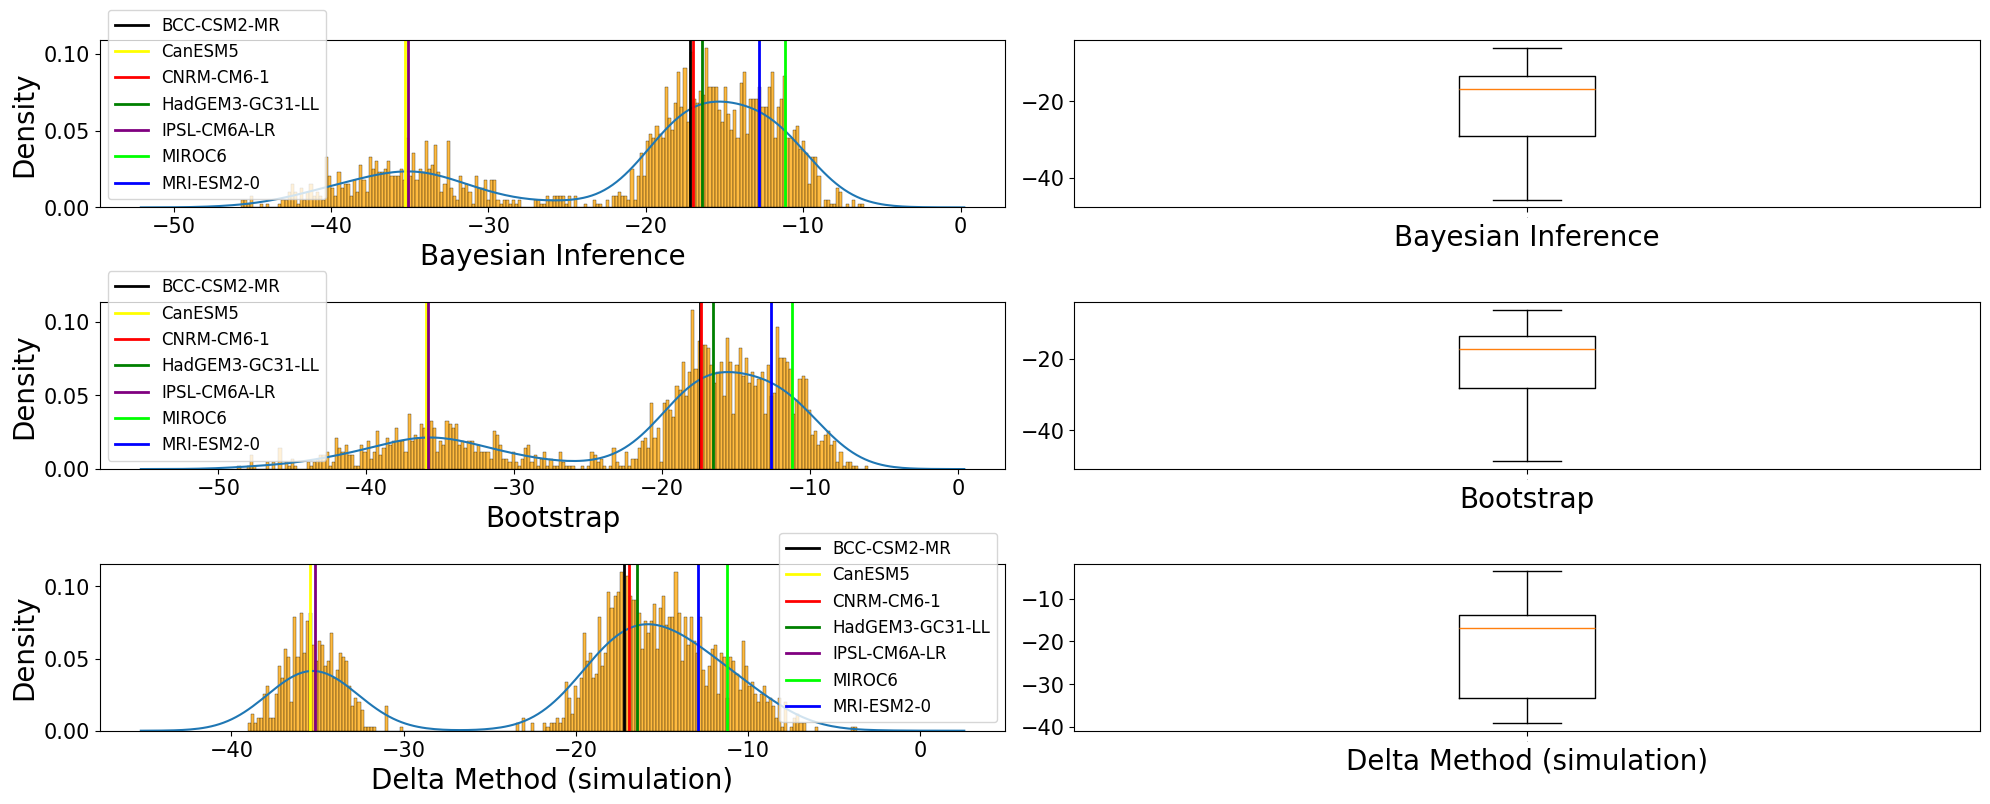

In [31]:
fig, axes = plt.subplots(3,2, figsize=(20,8))
colors = ["black","yellow","red","green","purple","lime","blue"]

x = np.linspace(np.mean(bayes_samples) - 3*np.std(bayes_samples), np.mean(bayes_samples) + 3*np.std(bayes_samples), 100)
sns.histplot(bayes_samples,bins=200,color="orange",stat="density", ax=axes[0][0])
sns.kdeplot(bayes_samples, ax=axes[0][0])
for index, (gcm, gcm_average) in enumerate(bayes_gcm_averages.items()):
    color = colors[index]
    axes[0][0].axvline(x = gcm_average, color = color, lw=2, label = gcm)
axes[0][0].set_xlabel("Bayesian Inference")
axes[0][0].legend(fontsize=12)
axes[0][0].xaxis.label.set_size(20)
axes[0][0].yaxis.label.set_size(20)
axes[0][0].xaxis.set_tick_params(labelsize=15)
axes[0][0].yaxis.set_tick_params(labelsize=15)

sns.histplot(boot_samples,bins=200,color="orange",stat="density", ax=axes[1][0])
sns.kdeplot(boot_samples, ax=axes[1][0])
for index, (gcm, gcm_average) in enumerate(boot_gcm_averages.items()):
    color = colors[index]
    axes[1][0].axvline(x = gcm_average, color = color, lw=2, label = gcm)
axes[1][0].set_xlabel("Bootstrap")
axes[1][0].legend(fontsize=12)
axes[1][0].xaxis.label.set_size(20)
axes[1][0].yaxis.label.set_size(20)
axes[1][0].xaxis.set_tick_params(labelsize=15)
axes[1][0].yaxis.set_tick_params(labelsize=15)

sns.histplot(delta_samples,bins=200,color="orange",stat="density", ax=axes[2][0])
sns.kdeplot(delta_samples, ax=axes[2][0])
for index, (gcm, gcm_average) in enumerate(delta_gcm_averages.items()):
    color = colors[index]
    axes[2][0].axvline(x = gcm_average, color = color, lw=2, label = gcm)
axes[2][0].set_xlabel("Delta Method (simulation)")
axes[2][0].legend(fontsize=12)
axes[2][0].xaxis.label.set_size(20)
axes[2][0].yaxis.label.set_size(20)
axes[2][0].xaxis.set_tick_params(labelsize=15)
axes[2][0].yaxis.set_tick_params(labelsize=15)

axes[0][1].boxplot(bayes_samples)
axes[0][1].set_xlabel("Bayesian Inference")
axes[0][1].xaxis.label.set_size(20)
axes[0][1].xaxis.set_tick_params(labelsize=.0001)
axes[0][1].yaxis.set_tick_params(labelsize=15)

axes[1][1].boxplot(boot_samples)
axes[1][1].set_xlabel("Bootstrap")
axes[1][1].xaxis.label.set_size(20)
axes[1][1].xaxis.set_tick_params(labelsize=.0001)
axes[1][1].yaxis.set_tick_params(labelsize=15)

axes[2][1].boxplot(delta_samples)
axes[2][1].set_xlabel("Delta Method (simulation)")
axes[2][1].xaxis.label.set_size(20)
axes[2][1].xaxis.set_tick_params(labelsize=.0001)
axes[2][1].yaxis.set_tick_params(labelsize=15)

fig.tight_layout()
# plt.show()
plt.savefig("../figures/ortiz_histograms.png", bbox_inches="tight")